## Step 1: Setup and Load Data

First, configure your burst analysis and create the pipeline (but don't run it yet).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add parent directory to path for scat_analysis
sys.path.insert(0, str(Path.cwd().parent))
# Add FLITS root directory to path for flits module
sys.path.insert(0, str(Path.cwd().parent.parent))

from scat_analysis.burstfit import FRBModel, FRBParams
from scat_analysis.burstfit_interactive import InitialGuessWidget

# Configuration
burst_name = "canonical"
data_path = Path("../plots/test/canonical_scattered_burst.npy")
plot_dir = Path("../plots/tutorial")
plot_dir.mkdir(parents=True, exist_ok=True)

# For synthetic data, we use a minimal dataset wrapper that skips BurstDataset processing
# (since the synthetic data is already at the correct resolution and normalized)
class SyntheticDataset:
    """Minimal dataset wrapper for pre-processed synthetic data."""
    def __init__(self, data, time, freq, df_MHz):
        self.data = data
        self.time = time
        self.freq = freq
        self.df_MHz = df_MHz
        self.dt_ms = time[1] - time[0]
        self.model = FRBModel(data=data, time=time, freq=freq, dm_init=0.0, df_MHz=df_MHz)

# Load synthetic data
data = np.load(data_path)
n_freq, n_time = data.shape

# Create matching axes (these match what was used to generate the data)
freq = np.linspace(0.4, 0.8, n_freq)  # GHz
time = np.linspace(0, 4.2, n_time)    # ms
df_MHz = (freq[1] - freq[0]) * 1000

# Create dataset
dataset = SyntheticDataset(data, time, freq, df_MHz)

print(f"Configuration for {burst_name.upper()} synthetic burst")
print(f"Data: {data_path}")
print(f"Shape: {data.shape}")
print(f"Time: {time[0]:.2f} - {time[-1]:.2f} ms")
print(f"Freq: {freq[0]:.2f} - {freq[-1]:.2f} GHz")

# True parameters used to generate this synthetic burst:
# Note: c0 will be calibrated later to match the data amplitude
print("\n" + "="*50)
print("TRUE PARAMETERS (for reference):")
print("="*50)
print("  c0     = (calibrated to match data)")
print("  t0     = 2.103 ms (arrival time)")
print("  gamma  = -1.0    (spectral index)")
print("  zeta   = 0.15 ms (intrinsic width)")
print("  tau_1ghz = 0.15 ms (scattering at 1 GHz)")
print("  alpha  = 4.0     (scattering index)")
print("="*50)

Configuration for CANONICAL synthetic burst
Data: ../plots/test/canonical_scattered_burst.npy
Shape: (128, 820)
Time: 0.00 - 4.20 ms
Freq: 0.40 - 0.80 GHz

TRUE PARAMETERS (for reference):
  c0     = (calibrated to match data)
  t0     = 2.103 ms (arrival time)
  gamma  = -1.0    (spectral index)
  zeta   = 0.15 ms (intrinsic width)
  tau_1ghz = 0.15 ms (scattering at 1 GHz)
  alpha  = 4.0     (scattering index)


## Step 2: Visualize the Data

Let's look at the synthetic burst before fitting.

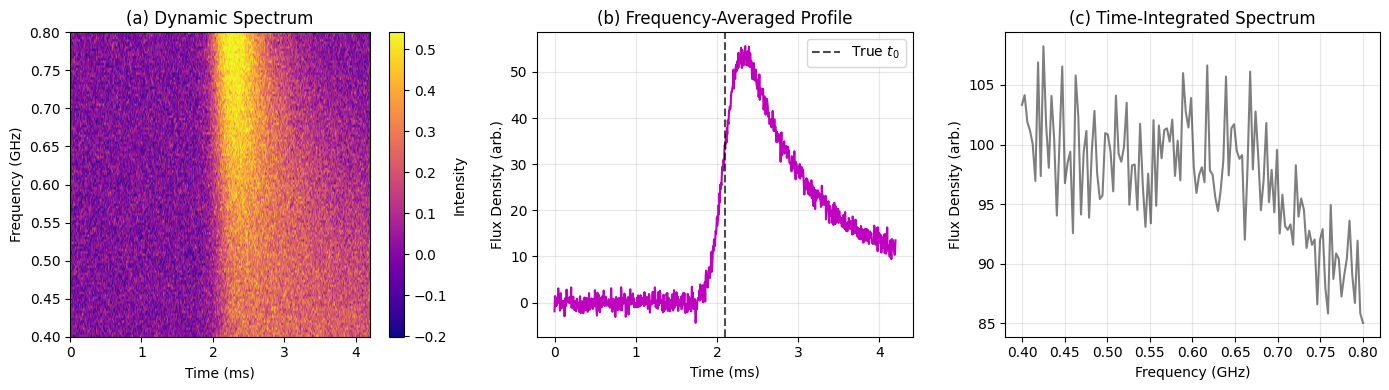

✓ Data loaded and visualized
  Peak time (from profile): 2.349 ms
  Note the scattering tail extending to later times at low frequencies!


In [ ]:
# Visualize the synthetic burst
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Dynamic spectrum
ax = axes[0]
vmin, vmax = np.percentile(data, [2, 98])
im = ax.imshow(data, aspect='auto', origin='lower',
               extent=[time[0], time[-1], freq[0], freq[-1]],
               vmin=vmin, vmax=vmax, cmap='plasma')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (GHz)')
ax.set_title('(a) Dynamic Spectrum')
plt.colorbar(im, ax=ax, label='Intensity')

# Time profile
ax = axes[1]
time_profile = np.sum(data, axis=0)
ax.plot(time, time_profile, 'm-', lw=1.5)
ax.axvline(2.103, color='k', ls='--', alpha=0.7, label='True $t_0$')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Flux Density (arb.)')
ax.set_title('(b) Frequency-Averaged Profile')
ax.legend()
ax.grid(alpha=0.3)

# Frequency spectrum
ax = axes[2]
freq_profile = np.sum(data, axis=1)
ax.plot(freq, freq_profile, 'k-', alpha = 0.5, lw=1.5)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Flux Density (arb.)')
ax.set_title('(c) Time-Integrated Spectrum')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Data loaded and visualized")
print(f"  Peak time (from profile): {time[np.argmax(time_profile)]:.3f} ms")
print(f"  Note the scattering tail extending to later times at low frequencies!")

## Step 3: Launch Interactive Widget

This displays an interactive interface with:
- **Sliders** for all model parameters
- **Real-time visualization** of Data, Model, Residual, and Time Profile
- **Auto-Optimize button** to refine from current slider values
- **Accept & Continue button** to save parameters

### How to Use:

1. **Adjust sliders** to make the model roughly match the data
   - Look at the time profile plot - does the peak align?
   - Check the residual - is it mostly noise with no structure?
   - Watch the χ² value decrease as you improve the fit

2. **Click "Auto-Optimize"** to let scipy refine your guess
   - The sliders will update automatically
   - This works best when you're already close to the right answer

3. **Click "Accept & Continue"** when satisfied
   - Parameters are saved and ready to use

### Parameter Guide:

- **c0 (amplitude)**: Overall brightness of the burst
- **t0 (arrival)**: Time of burst peak (ms)
- **gamma (width)**: Pulse width parameter (log scale: -2 = narrow, 2 = wide)
- **zeta (spectral width)**: Frequency structure (0.1 = smooth, 5 = variable)
- **tau_1ghz (scatter)**: Scattering time at 1 GHz (ms) - look for exponential tail
- **alpha (scatter index)**: Frequency dependence of scattering (typically 3.5-4.5)

In [17]:
# Create and display the interactive widget
guess_widget = InitialGuessWidget(
    dataset=dataset,
    model_key="M3"  # Full scattering model
)

# Display the widget
display(guess_widget.create_widget())

print("\n" + "="*70)
print("INTERACTIVE WIDGET INSTRUCTIONS")
print("="*70)
print("1. Adjust sliders to roughly match data (watch time profile!)")
print("2. Click 'Auto-Optimize' to refine with scipy")
print("3. Click 'Accept & Continue' when satisfied")
print("4. Run the next cell to see your parameters")
print("="*70)
print("\nTRUE VALUES TO AIM FOR:")
print("  t0 ≈ 2.1 ms, tau_1ghz ≈ 0.15 ms, gamma ≈ -1.0, zeta ≈ 0.15 ms")


INTERACTIVE WIDGET INSTRUCTIONS
1. Adjust sliders to roughly match data (watch time profile!)
2. Click 'Auto-Optimize' to refine with scipy
3. Click 'Accept & Continue' when satisfied
4. Run the next cell to see your parameters

TRUE VALUES TO AIM FOR:
  t0 ≈ 2.1 ms, tau_1ghz ≈ 0.15 ms, gamma ≈ -1.0, zeta ≈ 0.15 ms


## Step 4: Review Your Parameters

After clicking "Accept & Continue" in the widget, run this cell to see your refined parameters.

In [4]:
# Get the refined parameters from the widget
refined_params = guess_widget.get_params()

print("Your Refined Parameters:")
print("-" * 50)
print(f"  c0       = {refined_params.c0:.2f}")
print(f"  t0       = {refined_params.t0:.3f} ms")
print(f"  gamma    = {refined_params.gamma:.3f}")
print(f"  zeta     = {refined_params.zeta:.3f} ms")
print(f"  tau_1ghz = {refined_params.tau_1ghz:.3f} ms")
print(f"  alpha    = {refined_params.alpha:.2f}")

print("\n" + "-" * 50)
print("TRUE Parameters (for comparison):")
print("-" * 50)
print(f"  c0       ≈ 182")
print(f"  t0       = 2.103 ms")
print(f"  gamma    = -1.000")
print(f"  zeta     = 0.150 ms")
print(f"  tau_1ghz = 0.150 ms")
print(f"  alpha    = 4.00")

Your Refined Parameters:
--------------------------------------------------
  c0       = 111.36
  t0       = 2.092 ms
  gamma    = -0.500
  zeta     = 0.160 ms
  tau_1ghz = 0.221 ms
  alpha    = 3.00

--------------------------------------------------
TRUE Parameters (for comparison):
--------------------------------------------------
  c0       ≈ 182
  t0       = 2.103 ms
  gamma    = -1.000
  zeta     = 0.150 ms
  tau_1ghz = 0.150 ms
  alpha    = 4.00


## Step 5: Compare Your Fit to the True Model

Let's visualize how well your parameters match the data compared to the true parameters.

Calibrated true c0 = 120.77
(This ensures the ground-truth model matches the data amplitude)


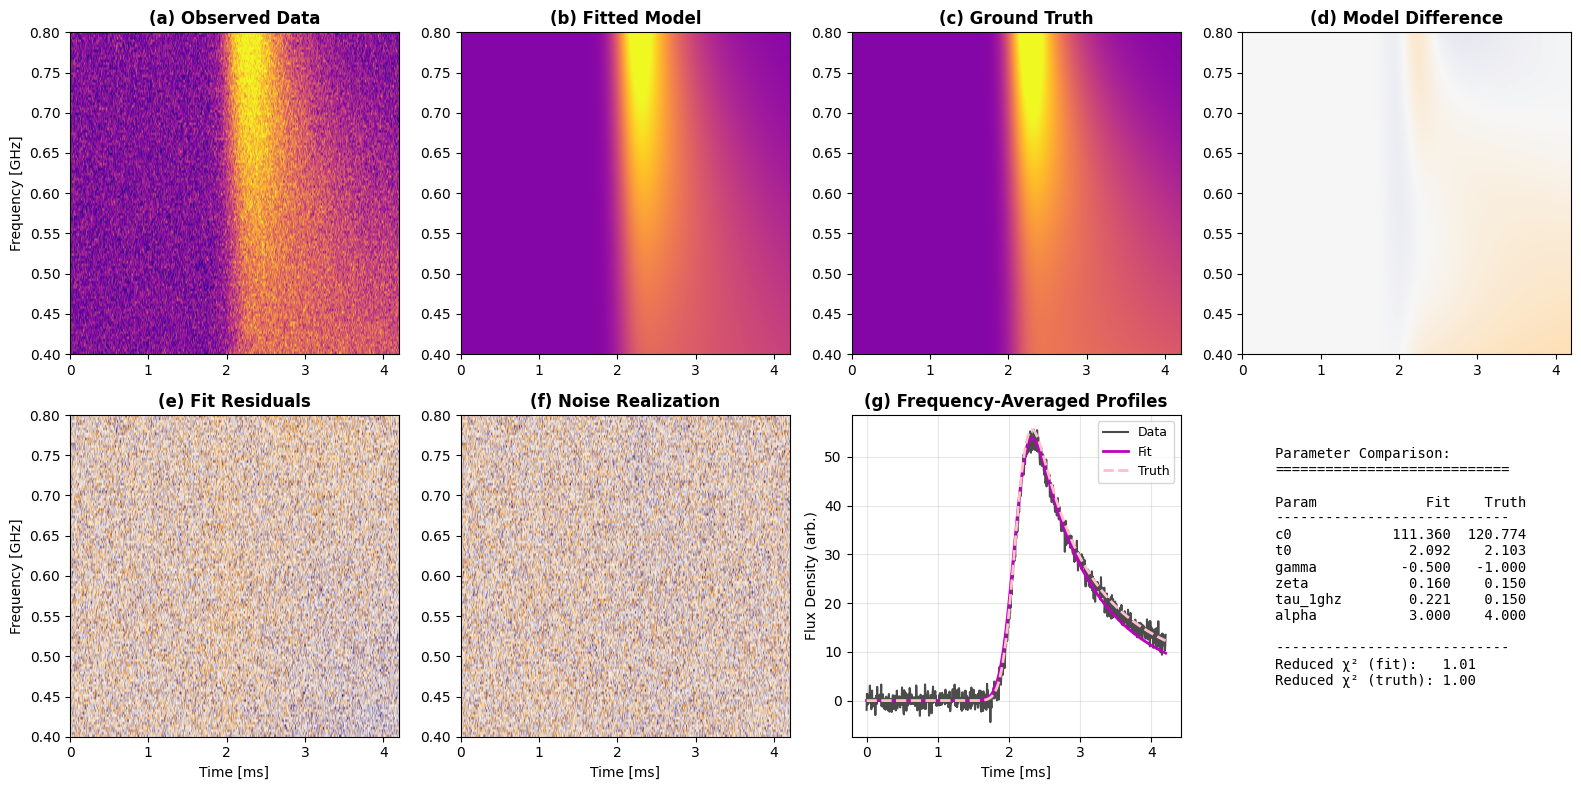


✓ Comparison saved to: ../plots/tutorial/fit_comparison.png


In [ ]:
# First, let's calibrate true_params.c0 to actually match the data
# The other parameters are known exactly, but c0 depends on normalization

# Known true parameters (except c0 which needs calibration)
true_params_uncalibrated = FRBParams(
    c0=100.0,  # Placeholder
    t0=2.103, gamma=-1.0, zeta=0.15,
    tau_1ghz=0.15, alpha=4.0, delta_dm=0.0
)

# Generate model with placeholder c0
test_model = dataset.model(true_params_uncalibrated, "M3")
test_profile = np.sum(test_model, axis=0)
data_profile = np.sum(data, axis=0)

# Scale c0 to match data amplitude
scale_factor = np.max(data_profile) / np.max(test_profile)
calibrated_c0 = 100.0 * scale_factor

# Create properly calibrated true parameters
true_params = FRBParams(
    c0=calibrated_c0, t0=2.103, gamma=-1.0, zeta=0.15,
    tau_1ghz=0.15, alpha=4.0, delta_dm=0.0
)

print(f"Calibrated true c0 = {calibrated_c0:.2f}")
print(f"(This ensures the ground-truth model matches the data amplitude)")

# Generate models
model_yours = dataset.model(refined_params, "M3")
model_true = dataset.model(true_params, "M3")

# Calculate residuals
residual_yours = data - model_yours
residual_true = data - model_true

# Plot comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

vmin, vmax = np.percentile(data, [2, 98])

# Row 1: Dynamic spectra
axes[0,0].imshow(data, aspect='auto', origin='lower',
                 extent=[time[0], time[-1], freq[0], freq[-1]],
                 vmin=vmin, vmax=vmax, cmap='plasma')
axes[0,0].set_title('(a) Observed Data', fontweight='bold')
axes[0,0].set_ylabel('Frequency [GHz]')

axes[0,1].imshow(model_yours, aspect='auto', origin='lower',
                 extent=[time[0], time[-1], freq[0], freq[-1]],
                 vmin=vmin, vmax=vmax, cmap='plasma')
axes[0,1].set_title('(b) Fitted Model', fontweight='bold')

axes[0,2].imshow(model_true, aspect='auto', origin='lower',
                 extent=[time[0], time[-1], freq[0], freq[-1]],
                 vmin=vmin, vmax=vmax, cmap='plasma')
axes[0,2].set_title('(c) Ground Truth', fontweight='bold')

# Difference between fitted model and ground truth
diff = model_yours - model_true
axes[0,3].imshow(diff, aspect='auto', origin='lower',
                 extent=[time[0], time[-1], freq[0], freq[-1]],
                 vmin=-0.3, vmax=0.3, cmap='PuOr')
axes[0,3].set_title('(d) Model Difference', fontweight='bold')

# Row 2: Residuals and profiles
axes[1,0].imshow(residual_yours, aspect='auto', origin='lower',
                 extent=[time[0], time[-1], freq[0], freq[-1]],
                 vmin=-0.3, vmax=0.3, cmap='PuOr')
axes[1,0].set_title('(e) Fit Residuals', fontweight='bold')
axes[1,0].set_ylabel('Frequency [GHz]')
axes[1,0].set_xlabel('Time [ms]')

axes[1,1].imshow(residual_true, aspect='auto', origin='lower',
                 extent=[time[0], time[-1], freq[0], freq[-1]],
                 vmin=-0.3, vmax=0.3, cmap='PuOr')
axes[1,1].set_title('(f) Noise Realization', fontweight='bold')
axes[1,1].set_xlabel('Time [ms]')

# Time profiles
ax = axes[1,2]
ax.plot(time, np.sum(data, axis=0), 'k-', lw=1.5, alpha=0.7, label='Data')
ax.plot(time, np.sum(model_yours, axis=0), 'b-', lw=2, label='Fit')
ax.plot(time, np.sum(model_true, axis=0), '--', color='hotpink', lw=2, label='Truth')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Flux Density (arb.)')
ax.set_title('(g) Frequency-Averaged Profiles', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Parameter comparison
ax = axes[1,3]
ax.axis('off')
param_text = "Parameter Comparison:\n" + "="*28 + "\n\n"
param_text += f"{'Param':<12} {'Fit':>8} {'Truth':>8}\n"
param_text += "-"*28 + "\n"
for name in ['c0', 't0', 'gamma', 'zeta', 'tau_1ghz', 'alpha']:
    yours = getattr(refined_params, name, 0)
    true = getattr(true_params, name, 0)
    param_text += f"{name:<12} {yours:>8.3f} {true:>8.3f}\n"

# Calculate chi-squared
noise_std = np.std(residual_true)
chi2_yours = np.sum(residual_yours**2) / (data.size * noise_std**2)
chi2_true = np.sum(residual_true**2) / (data.size * noise_std**2)
param_text += "\n" + "-"*28 + "\n"
param_text += f"Reduced chi2 (fit):   {chi2_yours:.2f}\n"
param_text += f"Reduced chi2 (truth): {chi2_true:.2f}\n"

ax.text(0.1, 0.9, param_text, transform=ax.transAxes,
        fontfamily='monospace', fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.savefig(plot_dir / 'fit_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison saved to: {plot_dir / 'fit_comparison.png'}")

## Step 6: Analyze Parameter Errors

How close did you get to the true values? Let's quantify the errors.

In [ ]:
# Calculate parameter errors
print("Parameter Recovery Analysis")
print("="*60)

errors = {}
for name in ['c0', 't0', 'gamma', 'zeta', 'tau_1ghz', 'alpha']:
    yours = getattr(refined_params, name, 0)
    true = getattr(true_params, name, 0)
    
    if true != 0:
        pct_error = 100 * (yours - true) / abs(true)
    else:
        pct_error = 100 * (yours - true)
    
    errors[name] = pct_error
    
    status = "[OK]" if abs(pct_error) < 20 else "[~]" if abs(pct_error) < 50 else "[X]"
    print(f"{status} {name:12s}: {yours:8.3f} (true: {true:8.3f}) -> {pct_error:+6.1f}% error")

print("\n" + "="*60)

# Overall assessment
good_params = sum(1 for e in errors.values() if abs(e) < 20)
ok_params = sum(1 for e in errors.values() if 20 <= abs(e) < 50)
bad_params = sum(1 for e in errors.values() if abs(e) >= 50)

print(f"Results: {good_params} excellent [OK], {ok_params} acceptable [~], {bad_params} poor [X]")

if good_params >= 4:
    print("\nThe fit is excellent!")
    print("   These parameters would make an excellent starting point for MCMC.")
elif good_params >= 2:
    print("\nMost parameters are reasonable.")
    print("   Try adjusting the sliders for the parameters marked [~] or [X].")
else:
    print("\nKeep practicing! Try these tips:")
    print("   - Start with t0: match the peak position in the time profile")
    print("   - Then tau_1ghz: look at the scattering tail at low frequencies")
    print("   - Finally gamma: adjust to match the spectral slope")

Parameter Recovery Analysis
✓ c0          :  111.360 (true:  120.774) →   -7.8% error
✓ t0          :    2.092 (true:    2.103) →   -0.5% error
✗ gamma       :   -0.500 (true:   -1.000) →  +50.0% error
✓ zeta        :    0.160 (true:    0.150) →   +6.7% error
⚠ tau_1ghz    :    0.221 (true:    0.150) →  +47.0% error
⚠ alpha       :    3.000 (true:    4.000) →  -25.0% error

Results: 3 excellent (✓), 2 acceptable (⚠), 1 poor (✗)

 Most parameters are reasonable.
   Try adjusting the sliders for the parameters marked ⚠ or ✗.


## Summary

You've learned to use the interactive widget to refine FRB scattering model parameters!

### Key Concepts:

1. **The Model Parameters:**
   - `c0`: Overall amplitude scaling
   - `t0`: Arrival time of the burst peak
   - `gamma`: Spectral index (negative = brighter at low freq)
   - `zeta`: Intrinsic pulse width (ms)
   - `tau_1ghz`: Scattering timescale at 1 GHz (ms)
   - `alpha`: Frequency scaling of scattering (tau ~ nu^-alpha, typically ~4)

2. **Visual Diagnostics:**
   - **Time Profile**: Does the model peak align with data? Is the tail shape right?
   - **Residual**: Should look like random noise when fit is good
   - **Dynamic Spectrum**: Model should match the frequency-dependent structure

3. **Fitting Strategy:**
   - Start with `t0` - match the peak timing
   - Then `tau_1ghz` - match the exponential tail
   - Then `gamma` - match the spectral slope
   - Fine-tune `c0`, `zeta`, `alpha` for details

### When to Use This Workflow:

- When automated initial guesses fail
- For unusual bursts with atypical structure
- To develop intuition about parameter space
- Before running expensive MCMC fits

### Physics Note:

The scattering timescale scales as:

$$\tau(\nu) = \tau_{1\text{GHz}} \left(\frac{\nu}{1\,\text{GHz}}\right)^{-\alpha}$$

With alpha ~ 4 (Kolmogorov turbulence), scattering at 400 MHz is ~40x stronger than at 800 MHz!